In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/home/snickels/Projects/parking-fhain-xberg/venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
sns.set_style("white")

In [3]:
explore_args = {
    "cmap": "Blues",
    "style_kwds": {
        "color": "black",
        "weight": 0.5,
        "opacity": 1,
        "fillOpacity": 0.8
    },
}

In [4]:
from copy import deepcopy

# I don't know why but when this is passed directly GeoDataFrame.explore removes the color
# element from style_kwds
def get_explore_args():
    return deepcopy(explore_args)

## Loading data

In [5]:
lor_gdf = geopandas.read_file("data/lor_friedrichshain_kreuzberg.geojson")
streets_processed_gdf = geopandas.read_file("data/extras/streets_processed.geojson")
drive_ways_gdf = geopandas.read_file("data/extras/drive_ways.geojson")
service_processed_gdf = geopandas.read_file("data/extras/service_processed.geojson")
estimated_parking_lanes_gdf = geopandas.read_file("data/parking/estimated_parking_lanes.geojson")
estimated_parking_spots_kfz_gdf = geopandas.read_file("data/parking/estimated_parking_spots_kfz.geojson")
demographics_age_df = pd.read_csv("data/demographics/demographics_age_of_inhabitants.csv", thousands=" ")
demographics_background_df = pd.read_csv("data/demographics/demographics_background_of_inhabitants.csv", thousands=" ", decimal=",")
registered_cars_gdf = geopandas.read_file("data/demographics/registered_cars.geojson")

## Preprocessing

In [6]:
demographics_df = pd.merge(demographics_age_df, demographics_background_df, on=("lor_number", "lor"))
demographics_df["lor"] = demographics_df["lor"].str.strip()

In [7]:
set(demographics_df["lor"].unique()).symmetric_difference(set(registered_cars_gdf["lor"].unique()))

{'Am Berlin Museum',
 'Forckenbeckplatz',
 'Gleisdreieck',
 'Gleisdreieck/Entwicklungsgebiet',
 'Graefekiez',
 'Graefekiez Nord',
 'Graefekiez Süd',
 'Köpenicker Straße',
 'Niederbarnim-straße',
 'Pettenkofer Straße',
 'Prinzenstraße',
 'Reichenberger Straße',
 'Reichenberger Straße Ost',
 'Reichenberger Straße West',
 'Revaler Straße',
 'Wismarplatz',
 'Wriezener Bahnhof',
 'Wriezener Bahnhof/Entwicklungsgebiet'}

## Calculate number of parking spots per LOR

In [8]:
estimated_parking_spots_kfz_lor_gdf = estimated_parking_spots_kfz_gdf.sjoin(lor_gdf, how="inner")

In [9]:
parking_spot_count_per_lor = estimated_parking_spots_kfz_lor_gdf \
    .groupby("PLR_NAME") \
    .size() \
    .to_frame("parking_spot_count") \
    .reset_index()

In [10]:
parking_spot_count_per_lor.head(5)

,PLR_NAME,parking_spot_count
0,Am Berlin Museum,983
1,Andreasviertel,3542
2,Askanischer Platz,2297
3,Barnimkiez,1397
4,Boxhagener Platz,1663


In [11]:
estimated_parking_spots_kfz_old_lor_gdf = estimated_parking_spots_kfz_gdf \
    .sjoin(registered_cars_gdf, how="inner")

In [12]:
parking_spot_count_per_old_lor = estimated_parking_spots_kfz_old_lor_gdf \
    .groupby("lor") \
    .size() \
    .to_frame("parking_spot_count") \
    .reset_index()

In [13]:
parking_spot_count_per_old_lor.head(5)

,lor,parking_spot_count
0,Andreasviertel,3799
1,Askanischer Platz,2301
2,Barnimkiez,1397
3,Boxhagener Platz,3697
4,Chamissokiez,2928


## Compare old LORs with new LORs

In [14]:
def get_lor_map():
    return lor_gdf.explore(
        column="PLR_NAME",
        legend=True,
        legend_kwds={"colorbar": False},
        style_kwds={"opacity": 0.4, "fillOpacity": 0.4},
        name="Friedrichshain-Kreuzberg"
    )

In [15]:
registered_cars_gdf.explore(
    m=get_lor_map(),
    column="lor",
    style_kwds={"opacity": 0.2, "fillOpacity": 0.2}
)

## Visualize registered cars with old LOR (from 2019)

In [16]:
registered_cars_parking_spot_count_gdf = registered_cars_gdf \
    .merge(parking_spot_count_per_old_lor, on="lor")

In [17]:
registered_cars_parking_spot_count_gdf["vehicles_per_parking"] = \
    (registered_cars_parking_spot_count_gdf["vehicles_overall"]
    / registered_cars_parking_spot_count_gdf["parking_spot_count"]).apply(lambda x: round(x, 2))

registered_cars_parking_spot_count_gdf["cars_per_parking"] = \
    (registered_cars_parking_spot_count_gdf["cars_only"]
    / registered_cars_parking_spot_count_gdf["parking_spot_count"]).apply(lambda x: round(x, 2))

In [18]:
registered_cars_parking_spot_count_gdf["parking_spots_per_km2"] = \
    (registered_cars_parking_spot_count_gdf["parking_spot_count"]
    / (registered_cars_parking_spot_count_gdf["lor size in m²"] / 10 ** 6)).apply(lambda x: round(x, 2))

In [32]:
registered_cars_parking_spot_count_gdf \
    .rename(columns={"cars_per_parking": "Cars per parking spot"}) \
    .explore(
        column="Cars per parking spot",
        **get_explore_args()
    )

In [20]:
# registered_cars_parking_spot_count_gdf["vehicles_per_parking"].sort_values()

In [33]:
registered_cars_parking_spot_count_gdf \
    .rename(columns={"vehicles_per_parking": "Vehicles per parking spot"}) \
    .explore(
        column="Vehicles per parking spot",
        vmax=1.7,
        **get_explore_args()
    )

In [34]:
registered_cars_parking_spot_count_gdf \
    .rename(columns={"parking_spots_per_km2": "Parking spots per km²"}) \
    .explore(
        column="Parking spots per km²",
        **get_explore_args()
    )

## Visualize registered cars with new LOR taking only districts that stayed the same

In [461]:
stats_df = registered_cars_gdf.merge(demographics_df, on="lor")
stats_df.columns

Index(['district ', 'lor', 'Bezirksregion', 'Prognoseraum', 'lor size in m²',
       'inhabitants_total', 'of_those_inhabitants_18+', 'vehicles_overall',
       'cars_only', 'vehicles_per_1000_inhabitants',
       'cars_per_1000_inhabitants', 'geometry', 'lor_number', 'total',
       'below age 6', ' 6 - 15', '15 - 18', '18 - 27', '27 - 45', '45 - 55',
       '55 - 65', '65 an more', 'of those female', 'of those immigrants',
       'total_of_inhabitants', 'total_in_percent(%)',
       'of_those_with_migration_background',
       'of_those_with_migration_background in percent (%)',
       'of_German_heritage', 'of_German_heritage_in_percent(%)',
       'germans_without_migration_background',
       'germans_without_migration_background_in_percent (%)',
       'germans_with_a_migration_background',
       'germans_with_a_migration_background_in_percent (%)',
       'number_of_non-Germans', 'number_of_non-Germans_in_percent(%)'],
      dtype='object')

In [462]:
# Only use districts that didn't change much in size
stats_df = stats_df[abs(stats_df["inhabitants_total"] - stats_df["total"]) / stats_df["inhabitants_total"] < 0.1]

In [463]:
stats_df = stats_df \
    .merge(parking_spot_count_per_lor, left_on="lor", right_on="PLR_NAME")

In [464]:
stats_df["vehicles_per_parking"] = (stats_df["vehicles_overall"] / stats_df["parking_spot_count"]).apply(lambda x: round(x, 2))
stats_df["cars_per_parking"] = (stats_df["cars_only"] / stats_df["parking_spot_count"]).apply(lambda x: round(x, 2))
stats_df["parking_spots_per_km2"] = (stats_df["parking_spot_count"] / (stats_df["lor size in m²"] / 10 ** 6)).apply(lambda x: round(x, 2))

We will not visualize the new LORs as they are rather incomplete..

## Covariate analysis

### Look into age

In [466]:
age_columns = [
    "below age 6",
    " 6 - 15",
    "15 - 18",
    "18 - 27",
    "27 - 45",
    "45 - 55",
    "55 - 65",
    "65 an more"
]

In [ ]:
model = sm.OLS(stats_df["cars_only"], sm.add_constant(stats_df[age_columns]))
result = model.fit()
result.summary()

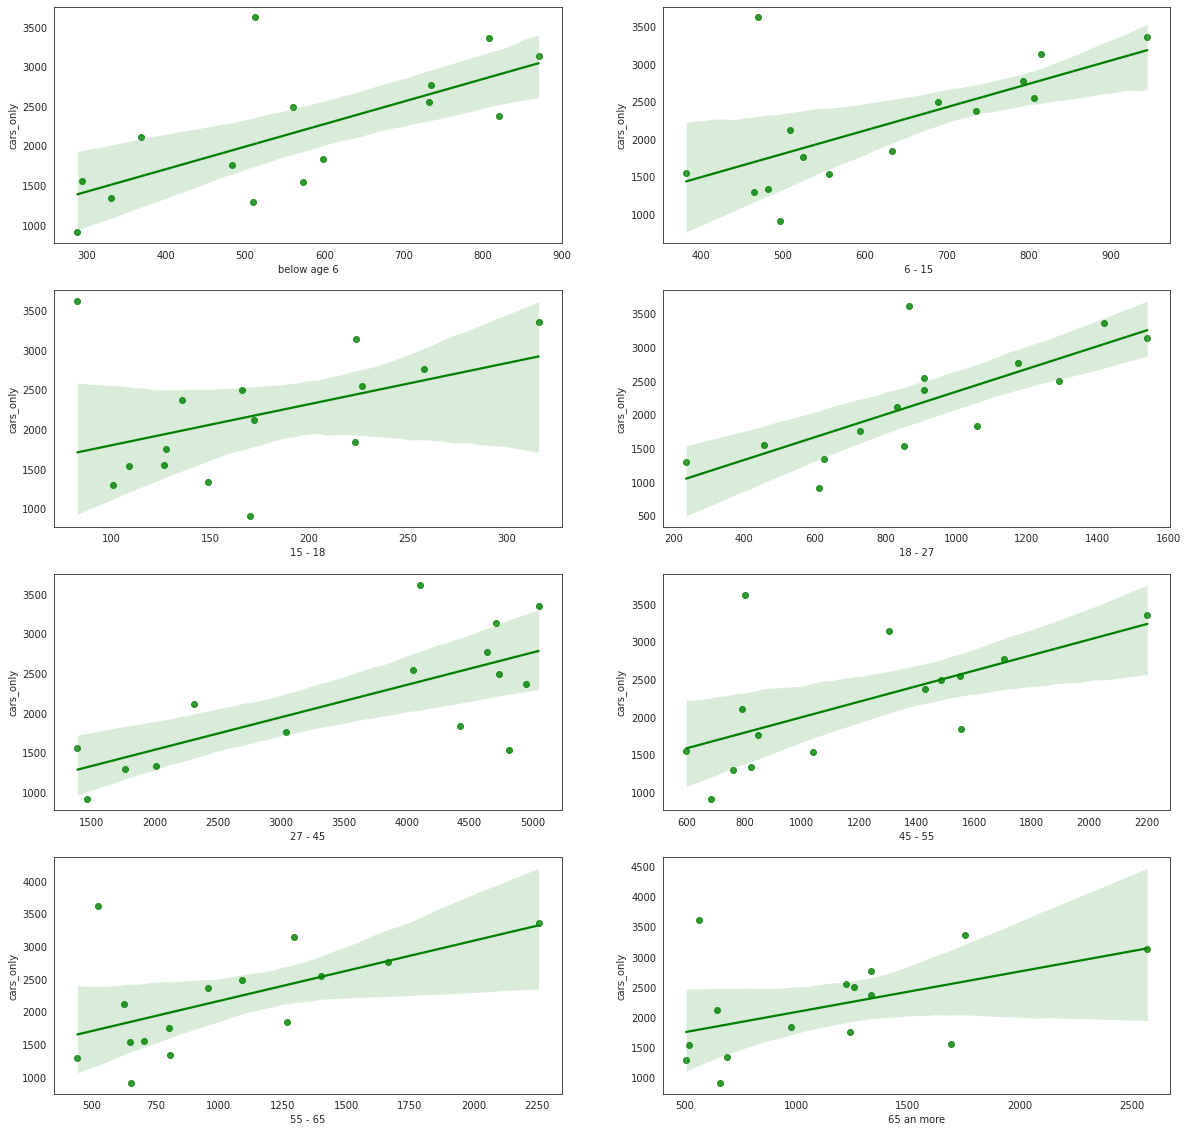

In [419]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
for i, age_column in enumerate(age_columns):
    ax = axs[i // 2][i % 2]
    sns.regplot(x=stats_df[age_column], y=stats_df["cars_only"], color='g', ax=ax)
plt.show()

In [ ]:
model = sm.OLS(stats_df["vehicles_overall"], sm.add_constant(stats_df[age_columns]))
result = model.fit()
result.summary()

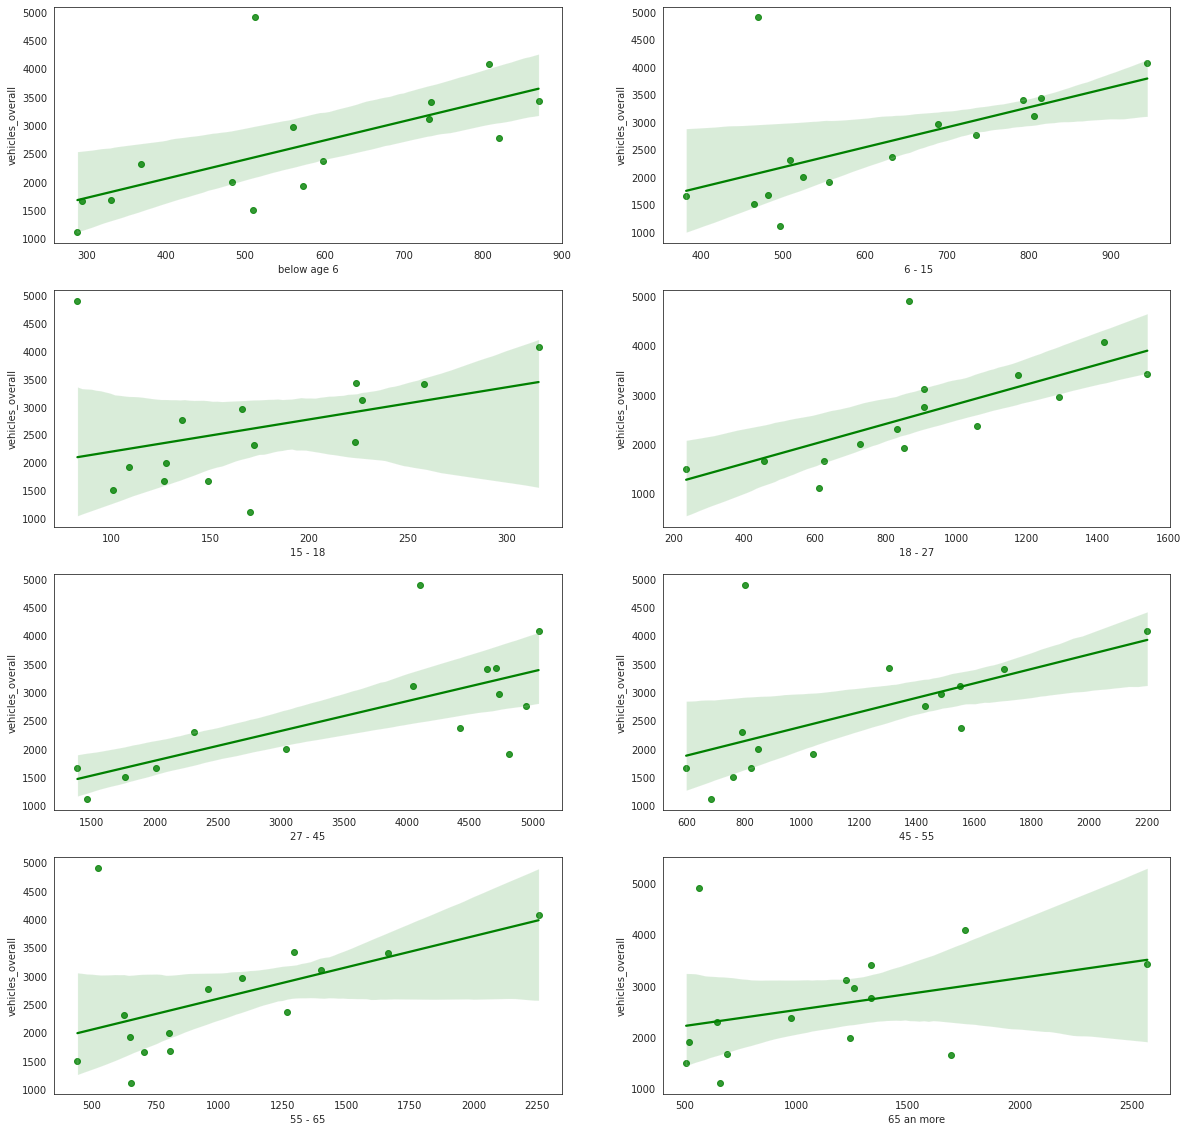

In [421]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
for i, age_column in enumerate(age_columns):
    ax = axs[i // 2][i % 2]
    sns.regplot(x=stats_df[age_column], y=stats_df["vehicles_overall"], color='g', ax=ax)
plt.show()

### Look into other factors

In [475]:
stats_df.columns

Index(['district ', 'lor', 'Bezirksregion', 'Prognoseraum', 'lor size in m²',
       'inhabitants_total', 'of_those_inhabitants_18+', 'vehicles_overall',
       'cars_only', 'vehicles_per_1000_inhabitants',
       'cars_per_1000_inhabitants', 'geometry', 'lor_number', 'total',
       'below age 6', ' 6 - 15', '15 - 18', '18 - 27', '27 - 45', '45 - 55',
       '55 - 65', '65 an more', 'of those female', 'of those immigrants',
       'total_of_inhabitants', 'total_in_percent(%)',
       'of_those_with_migration_background',
       'of_those_with_migration_background in percent (%)',
       'of_German_heritage', 'of_German_heritage_in_percent(%)',
       'germans_without_migration_background',
       'germans_without_migration_background_in_percent (%)',
       'germans_with_a_migration_background',
       'germans_with_a_migration_background_in_percent (%)',
       'number_of_non-Germans', 'number_of_non-Germans_in_percent(%)',
       'PLR_NAME', 'parking_spot_count', 'vehicles_per_parki

<AxesSubplot:xlabel='of those female', ylabel='cars_only'>

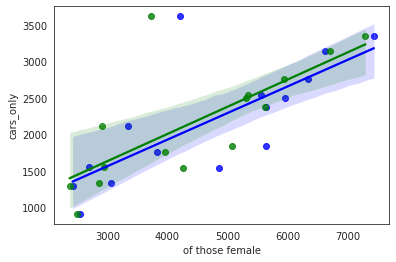

In [479]:
sns.regplot(x=stats_df["total"] - stats_df["of those female"], y=stats_df["cars_only"], color='b')
sns.regplot(x=stats_df["of those female"], y=stats_df["cars_only"], color='g')

<AxesSubplot:xlabel='of those female', ylabel='vehicles_overall'>

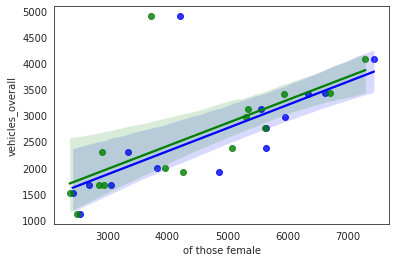

In [480]:
sns.regplot(x=stats_df["total"] - stats_df["of those female"], y=stats_df["vehicles_overall"], color='b')
sns.regplot(x=stats_df["of those female"], y=stats_df["vehicles_overall"], color='g')